# overview
도형/선 탐지 (VFM)
- Hough Transform + OpenCV :: 구림 -> dectection_v1
- YOLOv8 이런 모델로 테스트 :: 추가학습이 필요함
- SAM 테스트 ::: mask만 제공 → 클래스별 구분, 점선/실선 식별은 후처리 필요(정보)

## model : Zigeng/SlimSAM-uniform-77(경량화 버전)

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Zigeng/SlimSAM-uniform-77 model...


Keyword argument `boxes` is not a valid argument for this processor and will be ignored.
/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


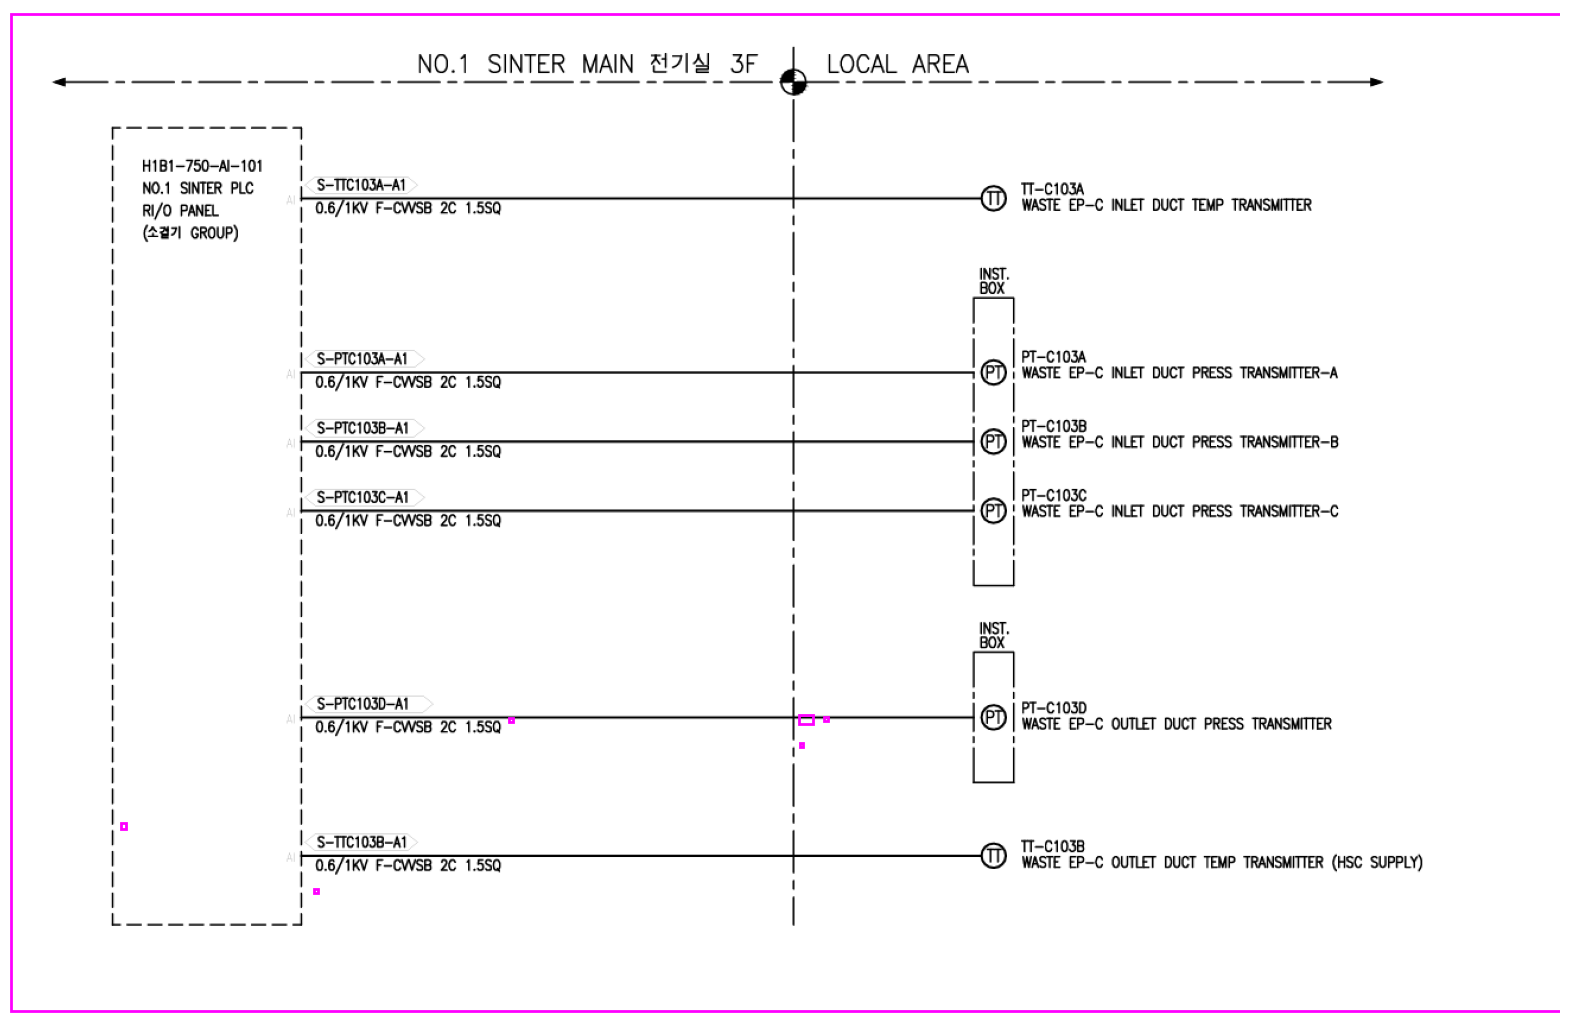

In [1]:
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import SamModel, SamProcessor
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
# 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.patches as patches

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

image_path = './data/easy_task_test05_v1.PNG'
image_cv = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

### 테스트할 이미지 부르기
image = Image.open(image_path).convert("RGB")

### 모델 부르기
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32

model_id = "Zigeng/SlimSAM-uniform-77"
print(f"Loading {model_id} model...")
model = SamModel.from_pretrained(
    model_id,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = SamProcessor.from_pretrained(model_id)

### SAM 입력 생성
W, H = image_pil.size
box = torch.tensor([[[0, 0, W, H]]], dtype=torch.float).to(device)  # 전체 이미지
inputs = processor(image_pil, boxes=box, return_tensors="pt").to(device)

# -------------------------------
# SAM Forward + Mask 후처리
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)
# -------------------------------
# Mask 후처리: 블록/선 구분
processed_objects = []

for mask in masks:
    mask_np = mask.cpu().numpy()       # [1,3,H,W]
    mask_np = np.squeeze(mask_np)      # [3,H,W]
    for i in range(mask_np.shape[0]):  # 3 채널 반복
        single_mask = mask_np[i]       # [H,W]
        mask_binary = (single_mask > 0).astype(np.uint8) * 255

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        mask_clean = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)
        mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h < 10:                            # 최소 크기 기준
                continue
            aspect_ratio = w / h
            obj_type = "line" if aspect_ratio > 3 or aspect_ratio < 0.55 else "block"             # 선 판단 기준
            processed_objects.append({
                "bbox": (x, y, w, h),
                "type": obj_type
            })

# -------------------------------
# 시각화
plt.figure(figsize=(20,20))
plt.axis('off')
ax = plt.gca()
ax.imshow(image_rgb)

for obj in processed_objects:
    x, y, w, h = obj["bbox"]
    if obj["type"]=="line":
        ax.plot([x, x+w], [y, y+h], color='cyan', linewidth=3)  # 선 느낌
    else:
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='magenta', facecolor='none'))


plt.show()

In [ ]:
# 현재 Cyan 라인이 안 보이는 이유: 너무 얇거나 mask 후처리에서 제거된 거 같음
# 최소 크기 조정 + aspect_ratio 기준 완화 + 선 표시 방법 변경

SyntaxError: invalid syntax (1812503455.py, line 1)